In [18]:
import os
import sys
import django
import pprint
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Change to the correct path
sys.path.append('/home/angsj/aRMSD/armsd')
sys.path.append('/home/angsj/NeuralForceField')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy.interpolate import interp1d

import torch

In [19]:
from ase.io import read
from ase.neb import NEB, SingleCalculatorNEB, NEBTools
from ase.optimize import MDMin, BFGS, QuasiNewton, FIRE
from ase.md.langevin import *
from ase.md.verlet import *
from ase import Atoms
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal,second
from ase.vibrations import Vibrations


from nff.io.ase import NeuralFF, AtomsBatch
from nff.data import Dataset
from nff.train import load_model, evaluate
from nff.md.utils import *
import nff.utils.constants as const
from nff.nn.tensorgrad import *

from nff.reactive_tools import *

In [20]:
from rdkit import RDLogger
import logging
import re
from rdkit.Chem.AllChem import MolFromSmiles, MolToSmiles, ReactionFromSmarts
from rdkit.Chem import AllChem as Chem
PERIODICTABLE = Chem.GetPeriodicTable()

## Specify the reactive GCNN FF

In [21]:
nff_dir = '../models/diels_alder/'
nff = NeuralFF.from_file(nff_dir, device='cuda:1')

## Neural NEB

In [22]:
import nglview

view_rxt = nglview.show_ase(xyz_to_ase_atoms("reactive_xyzs/da_r_m062x_def2svp.xyz"))
view_pdt = nglview.show_ase(xyz_to_ase_atoms("reactive_xyzs/da_p_m062x_def2svp.xyz"))

In [23]:
view_rxt

NGLWidget()

In [24]:
view_pdt

NGLWidget()

In [29]:
rxn_name = 'diels-alder'

images = neural_neb_ase('reactive_xyzs/da_r_m062x_def2svp.xyz', 'reactive_xyzs/da_p_m062x_def2svp.xyz', 
                         nff_dir, rxn_name,
                         steps=1, n_images=24, fmax=0.004)

      Step     Time          Energy         fmax
BFGS:    0 17:15:46       16.890726       14.0002
BFGS:    1 17:15:48       13.768718       14.5169


In [31]:
energies = []

for image in images:
    image = AtomsBatch(positions=torch.tensor(image.positions), 
                       numbers=torch.tensor(image.numbers),
                       cutoff=5.5, directed=True)
    
    image.set_calculator(nff)
    energies.append(image.get_potential_energy())
    
    highest_image_ind = np.argmax(np.array(energies))

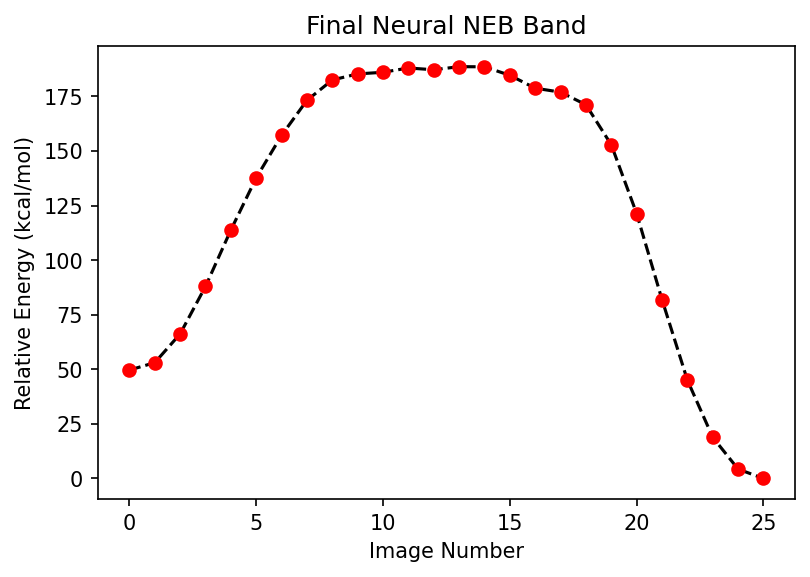

In [32]:
mpl.rcParams['figure.dpi'] = 150

rel_energy = []
for i in range(len(energies)):
    rel_energy.append((energies[i]-np.array(energies).min()) / (kcal/mol))

iteration = [i for i in range(len(energies))]
plt.scatter(iteration, rel_energy, c="r", label='image', zorder=2)

plt.plot(iteration, rel_energy, '--', c="black", label='image', zorder=1)


plt.title("Final Neural NEB Band")
plt.xlabel("Image Number")
plt.ylabel("Relative Energy (kcal/mol)")

plt.show()

In [34]:
ev_atoms = images[highest_image_ind].copy()

ev_atoms = AtomsBatch(ev_atoms, cutoff=5.5, directed=True)

ev_atoms.set_calculator(nff)

## Eigenvector Following from Neural NEB Guess

In [37]:
ev_atoms.calc

In [38]:
from ase import Atoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
from ase.vibrations import Vibrations
n2 = Atoms('N2', [(0, 0, 0), (0, 0, 1.1)],
           calculator=EMT())
BFGS(n2).run(fmax=0.01)
vib = Vibrations(n2)
vib.run()
vib.summary()

      Step     Time          Energy         fmax
BFGS:    0 17:23:48        0.440344        3.2518
BFGS:    1 17:23:48        0.264361        0.3475
BFGS:    2 17:23:48        0.262860        0.0805
BFGS:    3 17:23:48        0.262777        0.0015
---------------------
  #    meV     cm^-1
---------------------
  0    0.0       0.0
  1    0.0       0.0
  2    0.0       0.0
  3    1.4      11.5
  4    1.4      11.5
  5  152.7    1231.3
---------------------
Zero-point energy: 0.078 eV


In [35]:
# ev_run(ev_atoms, nff_dir, maxstepsize, maxstep, convergence, device, method = 'Powell')

device="cuda:1"

xyz, grad, xyz_all, rmslist, maxlist = ev_run(ev_atoms, nff_dir, 0.005, 1000, 0.03, 
                                              device, method='Powell')

Calculating Numerical Hessian using ASE
---------------------
  #    meV     cm^-1
---------------------
  0  137.3i   1107.5i
  1  120.7i    973.8i
  2   90.5i    730.2i
  3   85.9i    693.0i
  4   79.8i    643.9i
  5   70.0i    564.4i
  6   69.1i    557.3i
  7   59.4i    478.7i
  8   51.2i    413.3i
  9   49.4i    398.5i
 10   43.0i    346.9i
 11   38.3i    309.3i
 12   32.2i    260.0i
 13   20.4i    164.7i
 14   15.0i    121.2i
 15    1.5i     11.8i
 16    0.9i      6.9i
 17    0.1i      0.9i
 18   13.6     109.5
 19   20.7     166.7
 20   32.6     262.8
 21   54.3     438.1
 22   59.2     477.5
 23   66.2     534.0
 24   66.7     537.9
 25   71.9     579.9
 26   80.4     648.4
 27   81.6     658.5
 28  100.8     812.8
 29  106.8     861.4
 30  113.1     912.0
 31  121.8     982.1
 32  126.9    1023.4
 33  132.4    1068.1
 34  134.5    1084.9
 35  136.0    1097.3
 36  144.8    1167.9
 37  159.6    1287.1
 38  177.7    1432.9
 39  181.7    1465.4
 40  191.0    1540.7
 41  198.4    16

/home/saxelrod/Repo/projects/master/NeuralForceField/nff/reactive_tools/ev_following.py:54: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  eigenvalues, eigvecs = torch.eig(hessian, eigenvectors=True)
/home/saxelrod/Repo/projects/master/NeuralForceField/nff/reactive_tools/ev_following.py:69: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triang

RMS: 2.2586193084716797, MAX: 10.27251148223877
RMS: 2.2103111743927, MAX: 10.102277755737305
RMS: 2.166619300842285, MAX: 9.958767890930176
RMS: 2.124929904937744, MAX: 9.812399864196777
RMS: 2.0730392932891846, MAX: 9.609458923339844
RMS: 2.0157856941223145, MAX: 9.384958267211914
RMS: 1.9552855491638184, MAX: 9.152427673339844
RMS: 1.897788405418396, MAX: 8.935190200805664
RMS: 1.8404664993286133, MAX: 8.714498519897461
RMS: 1.7847813367843628, MAX: 8.495148658752441
RMS: 1.7316151857376099, MAX: 8.277437210083008
RMS: 1.6791267395019531, MAX: 8.06243896484375
RMS: 1.6272653341293335, MAX: 7.8509674072265625
RMS: 1.5767561197280884, MAX: 7.643864154815674
RMS: 1.5280818939208984, MAX: 7.442028045654297
RMS: 1.4804383516311646, MAX: 7.24637508392334
RMS: 1.4339408874511719, MAX: 7.057925224304199
RMS: 1.388678789138794, MAX: 6.877647876739502
RMS: 1.3447169065475464, MAX: 6.7064642906188965
RMS: 1.3020753860473633, MAX: 6.545005798339844
RMS: 1.2610138654708862, MAX: 6.39363288879394

KeyboardInterrupt: 

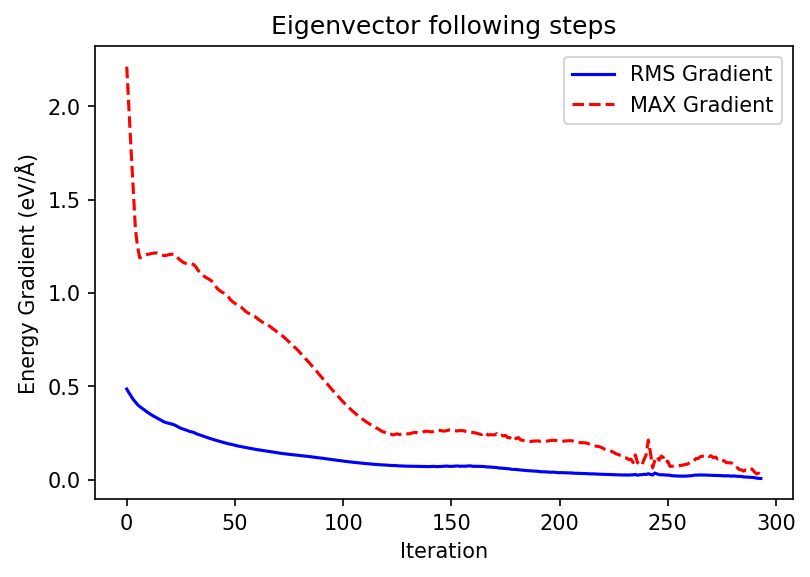

In [13]:
mpl.rcParams['figure.dpi'] = 150

iteration = [i for i in range(len(rmslist))]

rmslist1 = [float(i) for i in rmslist]
maxlist1 = [float(i) for i in maxlist]

plt.plot(iteration, rmslist1, '-', c="b", label='RMS Gradient')
plt.plot(iteration, maxlist1, '--', c="r", label='MAX Gradient')

plt.title("Eigenvector following steps")
plt.xlabel("Iteration")
plt.ylabel("Energy Gradient (eV/Å)")
plt.legend(loc='upper right')

plt.show()

### Comparing the structural difference between true TS and each step of the eigenvector following process

In [16]:
nrrmsdlist = []

f = open('reactive_xyzs/da_ts_m062x_def2svp.xyz', "r")
lines = f.readlines()
ts_geom_xyz = "{}\n\n".format(len(ev_atoms.numbers))
for line in lines[2:]:
    ts_geom_xyz  = ts_geom_xyz  + ("{}\n".format(line))        


for j in range(xyz_all.shape[0]):
    neural_ev_xyz = "{}\n\n".format(len(ev_atoms.numbers))
    for i in range(len(ev_atoms.numbers)):
        neural_ev_xyz = neural_ev_xyz + ("{} {} {} {}\n".format(PERIODICTABLE.GetElementSymbol(int(ev_atoms.numbers[i])),
                                      xyz_all[j][i][0], 
                                      xyz_all[j][i][1], 
                                      xyz_all[j][i][2]))
        
    nrrmsdlist.append(kabsch(1, ts_geom_xyz, neural_ev_xyz, 0, 10000)['RMSD'][0])

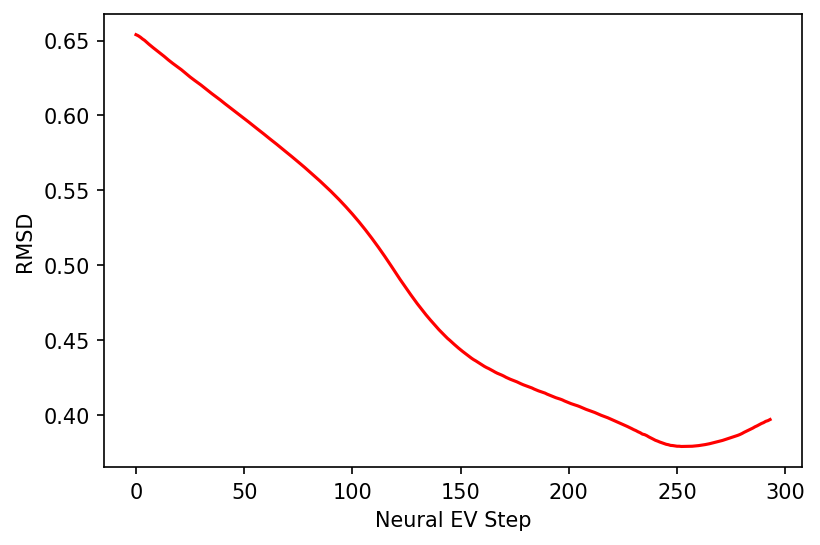

In [17]:
x = [i for i in range(xyz_all.shape[0])]

plt.xlabel('Neural EV Step')
plt.ylabel('RMSD')
plt.plot(x, nrrmsdlist, c='r') 

plt.show()

## Neural Hessian of the DFT refined TS structure

We used the output geometry of the neural eigenvector following algorithm and refined it with M06-2X/def2-SVP level of theory

In [20]:
# M06-2X/def2-SVP quantum mechanical TS coordinates

tsxyzfile = "reactive_xyzs/da_ts_m062x_def2svp.xyz"

In [21]:
ts_atoms = AtomsBatch(xyz_to_ase_atoms(tsxyzfile), cutoff=5.5, nbr_torch=True, directed=True)

ts_atoms.set_calculator(nff)

hessian = neural_hessian_ase(ts_atoms)

r = torch.Tensor([PERIODICTABLE.GetAtomicNumber(i) for i in ts_atoms.get_chemical_symbols()]).reshape(-1,len(ts_atoms.get_chemical_symbols()))
xyz = torch.Tensor(ts_atoms.get_positions().reshape(-1,len(ts_atoms.get_positions()),3))

Calculating Numerical Hessian using ASE
Writing vib.eq.pckl
Writing vib.0x-.pckl
Writing vib.0x+.pckl
Writing vib.0y-.pckl
Writing vib.0y+.pckl
Writing vib.0z-.pckl
Writing vib.0z+.pckl
Writing vib.1x-.pckl
Writing vib.1x+.pckl
Writing vib.1y-.pckl
Writing vib.1y+.pckl
Writing vib.1z-.pckl
Writing vib.1z+.pckl
Writing vib.2x-.pckl
Writing vib.2x+.pckl
Writing vib.2y-.pckl
Writing vib.2y+.pckl
Writing vib.2z-.pckl
Writing vib.2z+.pckl
Writing vib.3x-.pckl
Writing vib.3x+.pckl
Writing vib.3y-.pckl
Writing vib.3y+.pckl
Writing vib.3z-.pckl
Writing vib.3z+.pckl
Writing vib.4x-.pckl
Writing vib.4x+.pckl
Writing vib.4y-.pckl
Writing vib.4y+.pckl
Writing vib.4z-.pckl
Writing vib.4z+.pckl
Writing vib.5x-.pckl
Writing vib.5x+.pckl
Writing vib.5y-.pckl
Writing vib.5y+.pckl
Writing vib.5z-.pckl
Writing vib.5z+.pckl
Writing vib.6x-.pckl
Writing vib.6x+.pckl
Writing vib.6y-.pckl
Writing vib.6y+.pckl
Writing vib.6z-.pckl
Writing vib.6z+.pckl
Writing vib.7x-.pckl
Writing vib.7x+.pckl
Writing vib.7y-.

### Projecting translational and rotational modes

In [22]:
force_constants_J_m_2, proj_vib_freq_cm_1, proj_hessian_eigvec = vib_analy(r.cpu().numpy(),xyz.cpu().numpy(),
                                                                           hessian)

## Reactive Langevin MD

Pairs of Langevin MD trajectories initiated in the vicinity of transition state in the forward and backward directions.

In [23]:
md_params = {
    'T_init': 298.15, # Temperature in K
    'friction': 0.0012, # Langevin friction coefficient
    'time_step': 1 , 
    'thermostat': Langevin, 
    'steps': 500,
    'save_frequency': 1, # Save every n frames
    'nbr_list_update_freq': 5, # Neighbor list update frequency
    'thermo_filename': './thermo1.log', 
    'traj_filename': './atom1.traj',
    'skip': 0
}

### Running *n_traj* pairs of reactive MD

In [24]:
n_traj = 1
device = "cuda:1"

In [25]:
for iteration in range(n_traj):
    
    # Sampling of initial structure and velocities
    
    disp_xyz, vel_plus, vel_minus = reactive_normal_mode_sampling(xyz.cpu().numpy(),
                                                              force_constants_J_m_2, 
                                                              proj_vib_freq_cm_1, 
                                                              proj_hessian_eigvec,
                                                              md_params['T_init'])
    
    for sign in ['minus','plus']:

        reactmdatoms = Atoms(symbols=[PERIODICTABLE.GetElementSymbol(int(i)) for i in list(r.reshape(-1))],
                               positions=torch.Tensor(disp_xyz.reshape(-1,3)),
                               pbc=False)
        
        reactmd_atoms = AtomsBatch(reactmdatoms, cutoff=5.5, nbr_torch=True, directed=True)
        
        nff_ase = NeuralFF.from_file(nff_dir, device=device)
        reactmd_atoms.set_calculator(nff_ase)
        
        if sign == 'minus':            
            vel = vel_minus
        else:            
            vel = vel_plus    
            
        react_nvt = Reactive_Dynamics(reactmd_atoms, vel, md_params)
        react_nvt.run()

        react_nvt.save_as_xyz("test_iter{}_{}.xyz".format(iteration, sign))

/home/angsj/anaconda3/envs/htvs/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'nff.nn.models.schnet.SchNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/angsj/anaconda3/envs/htvs/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/angsj/anaconda3/envs/htvs/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original

Time[ps]      Etot[eV]     Epot[eV]     Ekin[eV]    T[K]
0.0000           8.8834       8.4079       0.4755   204.4

0.0010           8.8863       8.4561       0.4302   184.9

0.0020           8.8905       8.5437       0.3467   149.0

0.0030           8.8928       8.6066       0.2862   123.0

0.0040           8.8943       8.6296       0.2647   113.8

0.0050           8.8949       8.6443       0.2506   107.7

0.0060           8.8964       8.6741       0.2223    95.6

0.0070           8.8988       8.6848       0.2140    92.0

0.0080           8.8980       8.6309       0.2671   114.8

0.0090           8.8916       8.5493       0.3422   147.1

0.0100           8.8886       8.5242       0.3644   156.6

0.0110           8.8933       8.5730       0.3203   137.7

0.0120           8.8992       8.6358       0.2634   113.2

0.0130           8.8976       8.6520       0.2456   105.6

0.0140           8.8946       8.6204       0.2742   117.9

0.0150           8.8890       8.5946       0.2944   126.5


0.1390           8.8522       7.9728       0.8794   378.0

0.1400           8.8487       7.9427       0.9060   389.4

0.1410           8.8462       7.9230       0.9232   396.8

0.1420           8.8505       7.9283       0.9222   396.4

0.1430           8.8508       7.9633       0.8875   381.4

0.1440           8.8523       8.0111       0.8413   361.6

0.1450           8.8518       8.0443       0.8074   347.0

0.1460           8.8501       8.0621       0.7881   338.7

0.1470           8.8478       8.0754       0.7724   332.0

0.1480           8.8547       8.0839       0.7708   331.3

0.1490           8.8559       8.0702       0.7857   337.7

0.1500           8.8527       8.0305       0.8221   353.4

0.1510           8.8547       7.9980       0.8567   368.2

0.1520           8.8561       8.0186       0.8374   359.9

0.1530           8.8604       8.1063       0.7541   324.1

0.1540           8.8669       8.2121       0.6548   281.4

0.1550           8.8675       8.2770       0.5905   253.

0.2860           8.8301       8.0866       0.7435   319.6

0.2870           8.8202       8.0271       0.7930   340.8

0.2880           8.8296       8.0180       0.8116   348.8

0.2890           8.8311       8.0033       0.8278   355.8

0.2900           8.8279       7.9440       0.8839   379.9

0.2910           8.8269       7.8824       0.9445   405.9

0.2920           8.8243       7.8770       0.9473   407.2

0.2930           8.8325       7.9349       0.8976   385.8

0.2940           8.8438       8.0076       0.8362   359.4

0.2950           8.8485       8.0226       0.8259   355.0

0.2960           8.8441       7.9736       0.8705   374.1

0.2970           8.8366       7.9499       0.8867   381.1

0.2980           8.8463       8.0017       0.8446   363.0

0.2990           8.8509       8.0623       0.7886   338.9

0.3000           8.8521       8.0612       0.7909   339.9

0.3010           8.8441       8.0220       0.8221   353.3

0.3020           8.8404       8.0159       0.8246   354.

0.4260           8.8546       7.9277       0.9270   398.4

0.4270           8.8595       7.8682       0.9913   426.1

0.4280           8.8605       7.8687       0.9918   426.3

0.4290           8.8624       7.8975       0.9649   414.7

0.4300           8.8658       7.8961       0.9697   416.8

0.4310           8.8664       7.8352       1.0312   443.2

0.4320           8.8658       7.7442       1.1215   482.0

0.4330           8.8603       7.6925       1.1678   501.9

0.4340           8.8606       7.7146       1.1460   492.5

0.4350           8.8639       7.7692       1.0947   470.5

0.4360           8.8603       7.8017       1.0587   455.0

0.4370           8.8534       7.8235       1.0299   442.7

0.4380           8.8503       7.8778       0.9725   418.0

0.4390           8.8613       7.9508       0.9104   391.3

0.4400           8.8603       7.9968       0.8636   371.2

0.4410           8.8578       8.0084       0.8494   365.1

0.4420           8.8534       8.0159       0.8375   360.

0.0690           8.8399       8.1198       0.7201   309.5

0.0700           8.8414       8.0538       0.7876   338.5

0.0710           8.8410       7.9708       0.8702   374.0

0.0720           8.8400       7.9099       0.9302   399.8

0.0730           8.8438       7.8969       0.9469   407.0

0.0740           8.8484       7.9133       0.9352   401.9

0.0750           8.8530       7.9117       0.9413   404.6

0.0760           8.8514       7.8820       0.9694   416.6

0.0770           8.8504       7.8547       0.9957   428.0

0.0780           8.8521       7.8417       1.0103   434.2

0.0790           8.8535       7.8017       1.0518   452.0

0.0800           8.8472       7.7002       1.1470   493.0

0.0810           8.8439       7.5553       1.2886   553.8

0.0820           8.8400       7.4125       1.4275   613.6

0.0830           8.8431       7.2989       1.5442   663.7

0.0840           8.8455       7.2061       1.6394   704.6

0.0850           8.8477       7.0993       1.7484   751.

0.2150           8.7387       7.1617       1.5771   677.8

0.2160           8.7509       7.1584       1.5924   684.4

0.2170           8.7479       7.1460       1.6019   688.5

0.2180           8.7503       7.1542       1.5960   686.0

0.2190           8.7527       7.1908       1.5619   671.3

0.2200           8.7579       7.2462       1.5117   649.7

0.2210           8.7690       7.3032       1.4658   630.0

0.2220           8.7653       7.3437       1.4216   611.0

0.2230           8.7585       7.3660       1.3924   598.5

0.2240           8.7633       7.3663       1.3970   600.4

0.2250           8.7630       7.3164       1.4466   621.7

0.2260           8.7623       7.2099       1.5524   667.2

0.2270           8.7547       7.0971       1.6576   712.4

0.2280           8.7474       7.0298       1.7176   738.2

0.2290           8.7489       7.0174       1.7315   744.2

0.2300           8.7464       7.0473       1.6990   730.2

0.2310           8.7451       7.0988       1.6462   707.

0.3640           8.7549       7.0394       1.7155   737.3

0.3650           8.7458       7.0579       1.6878   725.4

0.3660           8.7534       7.1413       1.6121   692.9

0.3670           8.7613       7.1836       1.5777   678.1

0.3680           8.7630       7.1024       1.6606   713.7

0.3690           8.7432       6.9688       1.7743   762.6

0.3700           8.7447       6.9290       1.8157   780.4

0.3710           8.7566       7.0157       1.7408   748.2

0.3720           8.7720       7.0903       1.6817   722.8

0.3730           8.7691       7.0604       1.7087   734.4

0.3740           8.7650       6.9974       1.7676   759.7

0.3750           8.7630       6.9897       1.7734   762.2

0.3760           8.7672       7.0360       1.7312   744.1

0.3770           8.7718       7.0815       1.6903   726.5

0.3780           8.7763       7.0601       1.7162   737.6

0.3790           8.7754       6.9659       1.8095   777.7

0.3800           8.7671       6.8690       1.8981   815.